In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
import time
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from keras.utils import to_categorical
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import catboost as cb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.inspection import permutation_importance
from imblearn.under_sampling import RandomUnderSampler
import re
import urllib.request
import requests
import lxml.html as lh
import pandas as pd
#from bs4 import BeautifulSoup, Comment
import pymongo
from keras.utils import np_utils

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/phishing-july/phish_8_july_phishing.csv
/kaggle/input/phishing-july/phish_8_july_alexa.csv
/kaggle/input/phishing-july/phishdb_8_july.csv


In [2]:
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
#Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        if feature_name not in ['Result']:
            max_value = df[feature_name].astype(float).max()
            min_value = df[feature_name].astype(float).min()
            if max_value > min_value:
                result[feature_name] = (df[feature_name].astype(float) - min_value) / (max_value - min_value)
    return result

df_alexa = pd.read_csv("../input/phishing-july/phish_8_july_alexa.csv")
df_phish = pd.read_csv("../input/phishing-july/phishdb_8_july.csv")

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig('./random_forest_cm.png')

In [3]:
df_alexa['phishing'] = 0
df_phish['phishing'] = 1

In [4]:
print(len(df_alexa.columns))
print(len(df_phish.columns))

198
160


In [5]:
frames = [df_alexa, df_phish]
df = pd.concat(frames)

In [6]:
df.head()

,CDN,Server,Web Master,Web Server,_id,ads,ads_ad-analytics,ads_ad-blocking,ads_ad-exchange,ads_ad-network,...,widgets_wordpress-plugins,phishing,ads_bitcoin,hosting_french-hosting,hosting_italian-hosting,hosting_swiss-hosting,hosting_wordpress-hosting,shop_woocommerce-extension,shop_wordpress-plugins,widgets_joomla-module
0,NaN,NaN,NaN,NaN,https://youtube.com,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2.0,3.0,https://jd.com,2.0,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,4.0,4.0,https://amazon.com,17.0,0.0,NaN,0.0,0.0,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,2.0,3.0,https://zoom.us,11.0,0.0,NaN,1.0,2.0,...,3.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,2.0,9.0,https://sina.com.cn,27.0,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df = df.drop('_id', axis=1)
df = df.drop('description', axis=1)
df = df.drop('title', axis=1)
df = df.drop('http', axis=1)
df = df.drop('https', axis=1)
df = df.drop('url', axis=1)
df = df.drop('CDN', axis=1)
df = df.drop('Server', axis=1)
df = df.drop('alexa', axis=1)
df = df.drop('status', axis=1)

In [8]:
df.head()

,Web Master,Web Server,ads,ads_ad-analytics,ads_ad-blocking,ads_ad-exchange,ads_ad-network,ads_ad-server,ads_ads-txt,ads_adult,...,widgets_wordpress-plugins,phishing,ads_bitcoin,hosting_french-hosting,hosting_italian-hosting,hosting_swiss-hosting,hosting_wordpress-hosting,shop_woocommerce-extension,shop_wordpress-plugins,widgets_joomla-module
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,4.0,17.0,0.0,NaN,0.0,0.0,1.0,1.0,NaN,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,3.0,11.0,0.0,NaN,1.0,2.0,1.0,NaN,NaN,...,3.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,9.0,27.0,NaN,NaN,NaN,NaN,NaN,19.0,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df = df.fillna(0)

In [10]:
df.head()

,Web Master,Web Server,ads,ads_ad-analytics,ads_ad-blocking,ads_ad-exchange,ads_ad-network,ads_ad-server,ads_ads-txt,ads_adult,...,widgets_wordpress-plugins,phishing,ads_bitcoin,hosting_french-hosting,hosting_italian-hosting,hosting_swiss-hosting,hosting_wordpress-hosting,shop_woocommerce-extension,shop_wordpress-plugins,widgets_joomla-module
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,4.0,17.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,3.0,11.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,...,3.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,9.0,27.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df['copyright_presence']

0         True
1        False
2        False
3        False
4        False
         ...  
73633    False
73634        0
73635    False
73636    False
73637    False
Name: copyright_presence, Length: 142518, dtype: object

In [12]:
df['privacy_policy'] = df['privacy_policy'].replace(to_replace ="NA", value =False)


df = df.replace(to_replace =1.0, value =1)
df = df.replace(to_replace =2.0, value =2)
df = df.replace(to_replace =3.0, value =3)
df = df.replace(to_replace =4.0, value =4)
df = df.replace(to_replace =5.0, value =5)
df = df.replace(to_replace =6.0, value =6)
df = df.replace(to_replace =7.0, value =7)
df = df.replace(to_replace =8.0, value =8)
df = df.replace(to_replace =9.0, value =9)
df = df.replace(to_replace =10.0, value =10)
df = df.replace(to_replace =11.0, value =11)
df = df.replace(to_replace =12.0, value =12)
df = df.replace(to_replace =13.0, value =13)
df = df.replace(to_replace =14.0, value =14)
df = df.replace(to_replace =15.0, value =15)
df = df.replace(to_replace =16.0, value =16)
df = df.replace(to_replace =17.0, value =17)
df = df.replace(to_replace =18.0, value =18)
df = df.replace(to_replace =19.0, value =19)
df = df.replace(to_replace =20.0, value =20)
df = df.replace(to_replace =21.0, value =21)
df = df.replace(to_replace =22.0, value =22)
df = df.replace(to_replace =23.0, value =23)
df = df.replace(to_replace =24.0, value =24)
df = df.replace(to_replace =25.0, value =25)
df = df.replace(to_replace =26.0, value =26)
df = df.replace(to_replace =27.0, value =27)
df = df.replace(to_replace =28.0, value =28)
df = df.replace(to_replace =29.0, value =29)
df = df.replace(to_replace =30.0, value =30)
df = df.replace(to_replace =31.0, value =31)
df = df.replace(to_replace =32.0, value =32)
df = df.replace(to_replace =33.0, value =33)
df = df.replace(to_replace =34.0, value =34)
df = df.replace(to_replace =35.0, value =35)
df = df.replace(to_replace =36.0, value =36)
df = df.replace(to_replace =37.0, value =37)
df = df.replace(to_replace =38.0, value =38)


df = df.replace(to_replace ="social-management-1.0", value ="social-management-1")
df = df.replace(to_replace ="social-management-2.0", value ="social-management-2")
df = df.replace(to_replace ="social-management-1.0", value ="social-management-1")


df = df.replace(to_replace ="multi-channel-1.0", value ="multi-channel-1")
df = df.replace(to_replace ="multi-channel-2.0", value ="multi-channel-2")
df = df.replace(to_replace ="multi-channel-3.0", value ="multi-channel-3")


df = df.replace(to_replace ="retargeting-/-remarketing-1.0", value ="retargeting-/-remarketing-1")
df = df.replace(to_replace ="retargeting-/-remarketing-2.0", value ="retargeting-/-remarketing-2")
df = df.replace(to_replace ="retargeting-/-remarketing-3.0", value ="retargeting-/-remarketing-3")
df = df.replace(to_replace ="retargeting-/-remarketing-4.0", value ="retargeting-/-remarketing-4")
df = df.replace(to_replace ="retargeting-/-remarketing-5.0", value ="retargeting-/-remarketing-5")

df = df.replace(to_replace ="social-management-1.0", value ="social-management-1")
df = df.replace(to_replace ="social-management-2.0", value ="social-management-2")

# hosting_australian-hosting- دانشگاه علوم پزشکی ایران
# hosting_australian-hosting-Thai JobJob News
#                 hosting_australian-hosting-سرمه دان(داروخانه اینترنتی دکتر طهماسبی)
# hosting_australian-hosting-人生を変える方法 Soul Design 心羽
#          hosting_canadian-hosting-https://core-zero.com
#                 hosting_canadian-hosting-https://iums.ac.ir
#                 hosting_canadian-hosting-https://sormedan.com
#                 hosting_canadian-hosting-https://thaijobjob.com

df['ads_retargeting-/-remarketing'] = df['ads_retargeting-/-remarketing'].replace(to_replace ="true", value =1)   
df['cms_social-management'] = df['cms_social-management'].replace(to_replace ="false", value =0)   
df['ads_multi-channel'] = df['ads_multi-channel'].replace(to_replace ="false", value =0)  
df['hosting'] = df['hosting'].replace(to_replace ="true", value =1)
                
df['hosting_australian-hosting'] = df['hosting_australian-hosting'].replace(to_replace =" دانشگاه علوم پزشکی ایران", value =0) 
df['hosting_australian-hosting'] = df['hosting_australian-hosting'].replace(to_replace ="Thai JobJob News", value =0) 
df['hosting_australian-hosting'] = df['hosting_australian-hosting'].replace(to_replace ="سرمه دان(داروخانه اینترنتی دکتر طهماسبی)", value =0) 
df['hosting_australian-hosting'] = df['hosting_australian-hosting'].replace(to_replace ="人生を変える方法 Soul Design 心羽", value =0) 
                
                
df['hosting_canadian-hosting'] = df['hosting_canadian-hosting'].replace(to_replace ="https://core-zero.com", value =0) 
df['hosting_canadian-hosting'] = df['hosting_canadian-hosting'].replace(to_replace ="https://iums.ac.ir", value =0)
df['hosting_canadian-hosting'] = df['hosting_canadian-hosting'].replace(to_replace ="https://sormedan.com", value =0) 
df['hosting_canadian-hosting'] = df['hosting_canadian-hosting'].replace(to_replace ="https://thaijobjob.com", value =0) 

df['hosting'] = df['hosting'].replace(to_replace ="australian-hosting-1", value ="australian-hosting-1.0")
df['hosting'] = df['hosting'].replace(to_replace ="australian-hosting-2", value ="australian-hosting-2.0")
df['hosting'] = df['hosting'].replace(to_replace ="australian-hosting-3", value ="australian-hosting-3.0")
df['hosting'] = df['hosting'].replace(to_replace ="australian-hosting-4", value ="australian-hosting-4.0")
df['hosting'] = df['hosting'].replace(to_replace ="australian-hosting-5", value ="australian-hosting-5.0")

df['hosting'] = df['hosting'].replace(to_replace ="canadian-hosting-1", value ="canadian-hosting-1.0")
df['hosting'] = df['hosting'].replace(to_replace ="canadian-hosting-2", value ="canadian-hosting-2.0")
df['hosting'] = df['hosting'].replace(to_replace ="canadian-hosting-3", value ="canadian-hosting-3.0")

In [13]:
#copyright_presence
#current_year_match_copyright
#http
#https
#privacy_policy

df['copyright_presence'] = df["copyright_presence"].astype(int)

In [14]:
df['current_year_match_copyright'] = df["current_year_match_copyright"].astype(int)

In [15]:
df['privacy_policy'] = df["privacy_policy"].astype(int)
df['hosting_australian-hosting'] = df["hosting_australian-hosting"].astype(int)
df['hosting_canadian-hosting'] = df["hosting_canadian-hosting"].astype(int)
df['ads_retargeting-/-remarketing'] = df["ads_retargeting-/-remarketing"].astype(int)
df['cms_social-management'] = df["cms_social-management"].astype(int)
df['ads_multi-channel'] = df["ads_multi-channel"].astype(int)
df['hosting'] = df["hosting"].astype(int)
# df['ads'] = df["ads"].astype(int)
# df['ads_retargeting-/-remarketing'] = df["ads_retargeting-/-remarketing"].astype(int)
# df['cms_social-management'] = df["cms_social-management"].astype(int)
# df['hosting'] = df["hosting"].astype(int)
# df['hosting_australian'] = df["hosting_australian"].astype(int)
# df['hosting_canadian'] = df["hosting_canadian"].astype(int)

In [16]:
# encode_text_dummy(df, 'ads_multi-channel')
# encode_text_dummy(df, 'ads_retargeting-/-remarketing')
# encode_text_dummy(df, 'cms_social-management')
# encode_text_dummy(df, 'hosting')
# encode_text_dummy(df, 'hosting_australian-hosting')
# encode_text_dummy(df, 'hosting_canadian-hosting')

In [17]:
# df['status'] = df["status"].astype(int)

In [18]:
df.columns

Index(['Web Master', 'Web Server', 'ads', 'ads_ad-analytics',
       'ads_ad-blocking', 'ads_ad-exchange', 'ads_ad-network', 'ads_ad-server',
       'ads_ads-txt', 'ads_adult',
       ...
       'widgets_wordpress-plugins', 'phishing', 'ads_bitcoin',
       'hosting_french-hosting', 'hosting_italian-hosting',
       'hosting_swiss-hosting', 'hosting_wordpress-hosting',
       'shop_woocommerce-extension', 'shop_wordpress-plugins',
       'widgets_joomla-module'],
      dtype='object', length=196)

In [19]:
print(df.dtypes.unique())

[dtype('float64') dtype('int64')]


In [20]:
x = {}
x['columns'] = df.columns
feature_names = []
for p in df.columns:
    if p!="phishing":
        feature_names.append(p)
x['dtype'] = []
for t in df.columns:
    x['dtype'].append(df[t].dtype)

In [21]:
df_col = pd.DataFrame(x)
df_col.to_csv('out.csv')

In [22]:
df.apply(pd.to_numeric)

,Web Master,Web Server,ads,ads_ad-analytics,ads_ad-blocking,ads_ad-exchange,ads_ad-network,ads_ad-server,ads_ads-txt,ads_adult,...,widgets_wordpress-plugins,phishing,ads_bitcoin,hosting_french-hosting,hosting_italian-hosting,hosting_swiss-hosting,hosting_wordpress-hosting,shop_woocommerce-extension,shop_wordpress-plugins,widgets_joomla-module
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,4.0,17.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,3.0,11.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,...,3.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,9.0,27.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73633,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

In [24]:
# df.to_csv('preprocessed.csv')

In [25]:
X = df.loc[:,df.columns != "phishing"].values
y = df["phishing"].values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0)

In [27]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train1)
# X_test = scaler.transform(X_test)

In [28]:
# Counter(y_train1)

In [29]:
# over_sampler = RandomOverSampler(random_state=42)
# X_train, y_train = over_sampler.fit_resample(X_train1, y_train1)

In [30]:
# foobarish

In [31]:
#Decision Tree
dtree_model = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)
result = confusion_matrix(y_test, dtree_predictions)
print('Confusion Matrix : ')
print(result)
result1 = classification_report(y_test, dtree_predictions)
print('Classification Report:')
print (result1)
result2=accuracy_score(y_test,dtree_predictions)
print("Accuracy: %.2f%%" % (result2 * 100.0))

Confusion Matrix : 
[[11642  2087]
 [  880 13895]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     13729
           1       0.87      0.94      0.90     14775

    accuracy                           0.90     28504
   macro avg       0.90      0.89      0.90     28504
weighted avg       0.90      0.90      0.90     28504

Accuracy: 89.59%


In [32]:
#Random Forest
rnd_clf=RandomForestClassifier(n_estimators = 400, criterion = 'entropy', random_state = 42)
rnd_clf.fit(X_train,y_train)
y_pred=rnd_clf.predict(X_test)
result = confusion_matrix(y_test, y_pred)
print('Confusion Matrix : ')
print(result)
result1 = classification_report(y_test, y_pred)
print('Classification Report:')
print (result1)
result2=accuracy_score(y_test,y_pred)
print("Accuracy: %.2f%%" % (result2 * 100.0))

Confusion Matrix : 
[[12050  1679]
 [  292 14483]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.92     13729
           1       0.90      0.98      0.94     14775

    accuracy                           0.93     28504
   macro avg       0.94      0.93      0.93     28504
weighted avg       0.93      0.93      0.93     28504

Accuracy: 93.09%


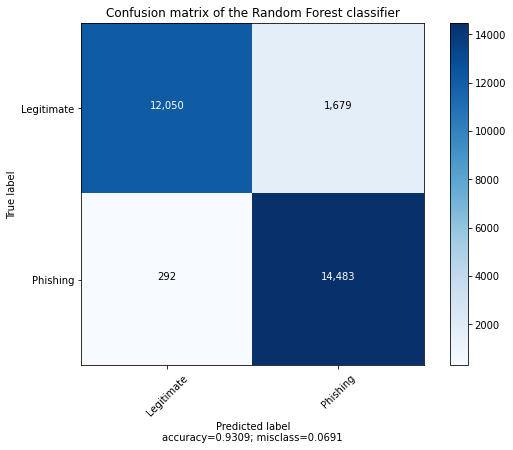

<Figure size 432x288 with 0 Axes>

In [33]:
plot_confusion_matrix(cm           = result, 
                      normalize    = False,
                      target_names = ['Legitimate', 'Phishing'],
                      title        = "Confusion matrix of the Random Forest classifier")


In [34]:
start_time = time.time()
importances = rnd_clf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rnd_clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.103 seconds


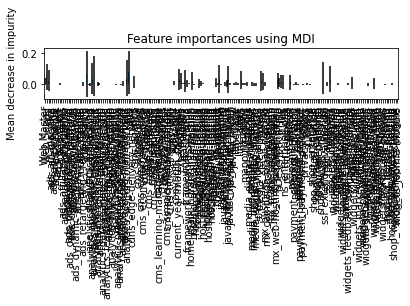

In [35]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig('./forest_importance.png')

In [36]:
forest_importances_20 = forest_importances.nlargest(20).to_dict()

In [37]:
forest_importances_20

{'cdn': 0.07915327060865482,
 'analytics': 0.06834619187581284,
 'analytics_audience-measurement': 0.05375637444065884,
 'Web Server': 0.04577728098429888,
 'ssl': 0.043694996056003,
 'analytics_visitor-count-tracking': 0.04328799188664458,
 'analytics_application-performance': 0.0358122031658274,
 'javascript': 0.035570153938831804,
 'widgets': 0.03523250795701633,
 'domains': 0.03190379498405403,
 'links': 0.030213160184200775,
 'javascript_javascript-library': 0.02897875305221895,
 'ads': 0.024669463741476057,
 'externalSites': 0.02352682533564039,
 'hosting': 0.023015641303889136,
 'framework': 0.022716297280444067,
 'nDescription': 0.022168419922285822,
 'mx': 0.02076910532941579,
 'mobile': 0.020456379882765892,
 'nTitle': 0.018591745915627504}

In [38]:
# features_important = ["cdn", "analytics", "analytics_audience-measurement", "Web Server", "ssl", "analytics_visitor-count-tracking", "analytics_application-performance", "javascript", "widgets", "domains", "links", "javascript_javascript-library",
# "ads", "externalSites", "hosting", "framework", "nDescription", "mx", "mobile", "nTitle"]

# print(len(features_important))

In [39]:
# plt.bar(range(len(forest_importances_20)), list(forest_importances_20.values()), align='center')
# plt.xticks(range(len(forest_importances_20)), list(forest_importances_20.keys()), rotation=90)
# # # for python 2.x:
# # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# # plt.xticks(range(len(D)), D.keys())  # in python 2.x
# plt.show()
# plt.savefig('./important_features.png')

In [40]:
# forest_importances2 = pd.Series(forest_importances_60.values(), index=features_important)

# fig2, ax2 = plt.subplots()
# forest_importances2.plot.bar(yerr=std, ax=ax2)
# ax2.set_title("Feature importances using MDI")
# ax2.set_ylabel("Mean decrease in impurity")
# fig2.tight_layout()
# fig2.savefig('./forest_importance.png')

Elapsed time to compute the importances: 2217.395 seconds


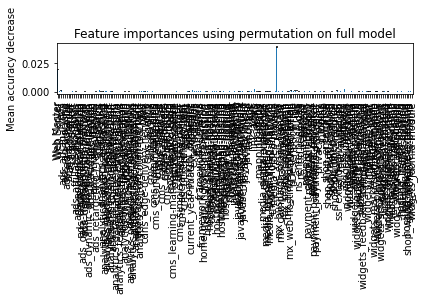

In [41]:
start_time = time.time()
result = permutation_importance(
    rnd_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances2 = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances2.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [42]:
forest_importances2_20 = forest_importances2.nlargest(20).to_dict()

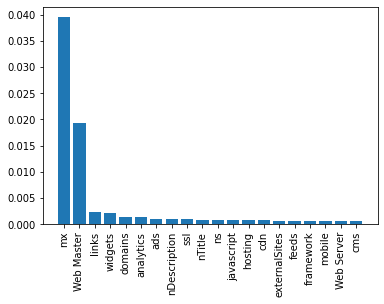

<Figure size 432x288 with 0 Axes>

In [43]:
plt.bar(range(len(forest_importances2_20)), list(forest_importances2_20.values()), align='center')
plt.xticks(range(len(forest_importances2_20)), list(forest_importances2_20.keys()), rotation=90)
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.show()
plt.savefig('./important_features.png')

In [44]:
#GNB
gnb = GaussianNB().fit(X_train, y_train)
y_pred = gnb.predict(X_test)
result = confusion_matrix(y_test, y_pred)
print('Confusion Matrix : ')
print(result)
result1 = classification_report(y_test, y_pred)
print('Classification Report:')
print (result1)
result2=accuracy_score(y_test,y_pred)
print("Accuracy: %.2f%%" % (result2 * 100.0))

Confusion Matrix : 
[[ 8696  5033]
 [  547 14228]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.63      0.76     13729
           1       0.74      0.96      0.84     14775

    accuracy                           0.80     28504
   macro avg       0.84      0.80      0.80     28504
weighted avg       0.84      0.80      0.80     28504

Accuracy: 80.42%


In [45]:
#KNN
#knn_clf=KNeighborsClassifier()
knn_clf = KNeighborsClassifier(n_neighbors = 20).fit(X_train, y_train)
ypred=knn_clf.predict(X_test) #These are the predicted output values

# evaluate predictions
result = confusion_matrix(y_test, ypred)
print('Confusion Matrix : ')
print(result)
result1 = classification_report(y_test, ypred)
print('Classification Report:')
print (result1)
result2 = accuracy_score(y_test,ypred)
print("Accuracy: %.2f%%" % (result2 * 100.0))

Confusion Matrix : 
[[11642  2087]
 [  466 14309]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     13729
           1       0.87      0.97      0.92     14775

    accuracy                           0.91     28504
   macro avg       0.92      0.91      0.91     28504
weighted avg       0.92      0.91      0.91     28504

Accuracy: 91.04%


In [46]:
#SVM
poly = svm.SVC(kernel="rbf").fit(X_train, y_train)
accuracy_poly = poly.score(X_test, y_test)
print(accuracy_poly)

0.877315464496211


In [47]:
pred_svm = poly.predict(X_test)

In [48]:
result = confusion_matrix(y_test, pred_svm)
print('Confusion Matrix : ')
print(result)

Confusion Matrix : 
[[11013  2716]
 [  781 13994]]


In [49]:
#data for XGBoost and CatBoost
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
# X_val,X_test_main,y_val,y_test_main = train_test_split(X_test,y_test,test_size = 0.5)

#label Encoding for XGBoost
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
# y_train = labelencoder.fit_transform(y_train)
# y_test = labelencoder.fit_transform(y_test)

In [50]:
Counter(y_train)

Counter({1: 58863, 0: 55151})

In [51]:
Counter(y_test)

Counter({0: 13729, 1: 14775})

In [52]:
#XGBoost
model = XGBClassifier(learning_rate = 0.335)
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [value for value in y_pred]

# evaluate predictions
result = confusion_matrix(y_test, predictions)
print('Confusion Matrix : ')
print(result)
result1 = classification_report(y_test, predictions)
print('Classification Report:')
print (result1)
result2 = accuracy_score(y_test,predictions)
print("Accuracy: %.2f%%" % (result2 * 100.0))

[17:36:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix : 
[[11955  1774]
 [  252 14523]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     13729
           1       0.89      0.98      0.93     14775

    accuracy                           0.93     28504
   macro avg       0.94      0.93      0.93     28504
weighted avg       0.93      0.93      0.93     28504

Accuracy: 92.89%


In [53]:
#CatBoost
clf = cb.CatBoostClassifier(depth=10, iterations= 200, l2_leaf_reg= 8, learning_rate= 0.085)
clf.fit(X_train,y_train)
y_pred_2 = clf.predict(X_test)
predictions = [value for value in y_pred_2]
# evaluate predictions
result = confusion_matrix(y_test, predictions)
print('Confusion Matrix : ')
print(result)
result1 = classification_report(y_test, predictions)
print('Classification Report:')
print (result1)
result2 = accuracy_score(y_test,predictions)
print("Accuracy: %.2f%%" % (result2 * 100.0))

0:	learn: 0.5959027	total: 298ms	remaining: 59.3s
1:	learn: 0.5250413	total: 523ms	remaining: 51.8s
2:	learn: 0.4680455	total: 751ms	remaining: 49.3s
3:	learn: 0.4263354	total: 978ms	remaining: 47.9s
4:	learn: 0.3947184	total: 1.2s	remaining: 47s
5:	learn: 0.3694688	total: 1.43s	remaining: 46.2s
6:	learn: 0.3490253	total: 1.66s	remaining: 45.6s
7:	learn: 0.3311695	total: 1.88s	remaining: 45.1s
8:	learn: 0.3174404	total: 2.1s	remaining: 44.7s
9:	learn: 0.3061494	total: 2.33s	remaining: 44.3s
10:	learn: 0.2962610	total: 2.56s	remaining: 44s
11:	learn: 0.2903236	total: 2.79s	remaining: 43.6s
12:	learn: 0.2848929	total: 3.01s	remaining: 43.3s
13:	learn: 0.2793594	total: 3.24s	remaining: 43s
14:	learn: 0.2744115	total: 3.48s	remaining: 42.9s
15:	learn: 0.2699969	total: 3.71s	remaining: 42.7s
16:	learn: 0.2662172	total: 3.94s	remaining: 42.4s
17:	learn: 0.2625422	total: 4.17s	remaining: 42.2s
18:	learn: 0.2597746	total: 4.4s	remaining: 41.9s
19:	learn: 0.2578521	total: 4.62s	remaining: 41.6s